# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [312]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

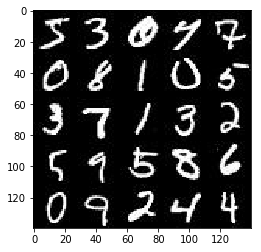

In [313]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot



mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

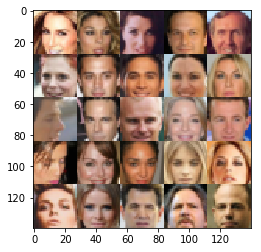

In [315]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [316]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [317]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="real_input")
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learn_rate = tf.placeholder(tf.float32, (), name="learn_rate")

    
    return real_inputs, z_inputs, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [537]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # Experimented with kernel initialization as seen on Slack forums.  Decided not to use it. 
    kernel_init = None #tf.truncated_normal_initializer(stddev=0.02, dtype=tf.float32)
    #tf.contrib.layers.xavier_initializer()
    #kernel_init = tf.contrib.layers.xavier_initializer_conv2d()
    
    alpha = 0.2
    keep_prob = 0.6  #I did a lot of experimenting with dropout.  I went as low as 0.3 for dropout (based on a paper I read) and
                     # I also tried keep_prob of 1 for no dropout.
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # I played around with the convolutional architecture quite a bit, trying 3 and 4 conv layers, adjusting the sizes, dropout, etc.
        #  Ended up deciding to skip batch normalization in the discriminator
        
        #layer1a = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        #layer1a = tf.layers.batch_normalization(layer1a, training=True)
        #layer1a = tf.maximum(alpha*layer1a, layer1a)
        #print(layer1a.shape)
        #28x28x64
        
        #layer1 = tf.nn.dropout(images, keep_prob)
        layer1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        #layer1 = tf.layers.batch_normalization(layer1, training=True)
        relu1 = tf.maximum(alpha*layer1, layer1)
        #print(relu1.shape)
        # 28x28x128
        
        layer2 = tf.nn.dropout(relu1, keep_prob)
        layer2 = tf.layers.conv2d(layer2, 256, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        #layer2 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(alpha*layer2, layer2)
        #print(relu2.shape)
        # 7x7x256
        
        layer3 = tf.nn.dropout(relu2, keep_prob)
        layer3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        #layer3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(alpha*layer3, layer3)
        #print(relu3.shape)
        # 4x4x512
        
        #flatten 
        flatten = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [538]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #The idea for a weight initializer was taken from the Slack forums for the DLND class.  I tried a few different ones.  
    kernel_init = tf.contrib.layers.xavier_initializer_conv2d(uniform=False)
    #kernel_init = tf.truncated_normal_initializer(stddev=0.02, dtype=tf.float32)  #tf.contrib.layers.xavier_initializer()
    alpha = 0   # After experimentation, decided to use regular RELU activation.
    keep_prob = 0.6 # was experimenting with dropout in generator.  Not entirely sure if this is a good, bad, or indifferent idea.
                    # only used it in one layer.
        
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        x_layer1 = tf.layers.dense(z, 7*7*512)
        #Reshape
        x_layer1 = tf.reshape(x_layer1, (-1, 7, 7, 512))
        #x_layer1 = tf.layers.batch_normalization(x_layer1, training=is_train)
        x_layer1 = tf.maximum(alpha * x_layer1, x_layer1)
        x_layer1 = tf.layers.batch_normalization(x_layer1, training=is_train)
        
        #7x7x512
        
        
        x_layer2 = tf.layers.conv2d_transpose(x_layer1, 256, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        x_layer2 = tf.layers.batch_normalization(x_layer2, training=is_train)
        x_layer2 = tf.maximum(alpha * x_layer2, x_layer2)
        x_layer2 = tf.layers.batch_normalization(x_layer2, training=is_train)
        
        
        #14x14x256
        x_layer3 = tf.nn.dropout(x_layer2, keep_prob)
        x_layer3 = tf.layers.conv2d_transpose(x_layer3, 128, 5, strides=1, padding='same', kernel_initializer=kernel_init)
        x_layer3 = tf.layers.batch_normalization(x_layer3, training=is_train)
        x_layer3 = tf.maximum(alpha * x_layer3, x_layer3)
        x_layer3 = tf.layers.batch_normalization(x_layer3, training=is_train)
        
        #print(x_layer3.shape)
        #14x14x128
        
        #x_layer4 = tf.nn.dropout(x_layer3, keep_prob)
        #x_layer4 = tf.layers.conv2d_transpose(x_layer4, 32, 5, strides=1, padding='same', kernel_initializer=kernel_init)
        #x_layer4 = tf.layers.batch_normalization(x_layer4, training=is_train)
        #x_layer4 = tf.maximum(alpha * x_layer4, x_layer4)
        #x_layer4 = tf.layers.batch_normalization(x_layer4, training=is_train)
        #14x14x64
        
        logits = tf.layers.conv2d_transpose(x_layer3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        #print(logits.shape)
        #28x28x3
    
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [539]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # THE FOLLOWING RELIED HEAVILY ON THE DCGAN notebook from Udacity course
    generate_out = generator(input_z, out_channel_dim, is_train=True)
    discrim_out_real, discrim_logits_real = discriminator(input_real, reuse=False)
    discrim_out_fake, discrim_logits_fake = discriminator(generate_out, reuse=True)
    
    discrim_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discrim_logits_real, labels=tf.ones_like(discrim_out_real)))
    discrim_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discrim_logits_fake, labels=tf.zeros_like(discrim_out_fake)))
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discrim_logits_fake, labels=tf.ones_like(discrim_out_fake)))    
                                   
    discrim_loss = discrim_loss_real + discrim_loss_fake
                          
    return discrim_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [540]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizedr
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #NOTE:  The following was based on the Udacity DCGAN notebook that was presented as part of the class
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):   
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)  
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [541]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [542]:
# Added this function to plot the losses at the end.
def plot_losses(losses):
    fig, ax = pyplot.subplots()
    loss_array = np.array(losses)
    pyplot.plot(loss_array.T[0], label='Discriminator')
    pyplot.plot(loss_array.T[1], label='Generator')
    pyplot.title("Training Losses")
    pyplot.legend()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [547]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    steps = 0
    check_balance_every=10
    print_every=50
    show_every=100
    losses = []
    
    # TODO: Build Model
    #tf.reset_default_graph()
    
    #followed Udacity class DCGAN notebook for the basics of train()
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):                               
                steps+=1
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                # Running the Generator twice here:  My idea was that this allowed me to make a stronger discriminator 
                # and still not overpower the generator.
                
                for i in range(2):
                    _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                
                # The following was a little heuristic I was playing around with to balance the D & G.  
                # Ended up commenting it out and just running the generator twice (see above).
                
                # Just grabbing the losses here.
                if steps % check_balance_every == 0:
                #     in_balance = False
                #     while not in_balance:
                    train_loss_d = sess.run(d_loss, feed_dict={input_real: batch_images, input_z: batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict={input_real: batch_images, input_z: batch_z})
                    losses.append((train_loss_d, train_loss_g))
                #         if train_loss_d > train_loss_g + 1.5:
                #             _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                #         elif train_loss_g > train_loss_d + 0.4:
                #             _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                #         else:
                #             in_balance = True
                
                if steps % print_every == 0:
                    print("Epoch {}, step {}   ".format(epoch_i +1, steps),
                         "Discriminator Loss: {:.4f}   ".format(train_loss_d),
                         "Generator Loss:  {:.4f}   ".format(train_loss_g))
                    
                if steps % show_every == 0:
                        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                        
            print("epoch {} finished".format(epoch_i +1))    
        #print plot of losses
        plot_losses(losses) 
        
        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1, step 50    Discriminator Loss: 1.4139    Generator Loss:  0.8377   
Epoch 1, step 100    Discriminator Loss: 1.4092    Generator Loss:  0.4927   


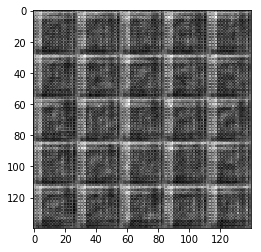

Epoch 1, step 150    Discriminator Loss: 2.0264    Generator Loss:  1.8738   
Epoch 1, step 200    Discriminator Loss: 1.1317    Generator Loss:  0.8411   


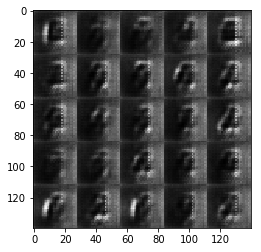

Epoch 1, step 250    Discriminator Loss: 1.1046    Generator Loss:  1.1466   
Epoch 1, step 300    Discriminator Loss: 1.2465    Generator Loss:  0.7644   


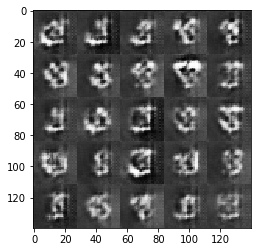

Epoch 1, step 350    Discriminator Loss: 1.7805    Generator Loss:  0.2496   
Epoch 1, step 400    Discriminator Loss: 1.3463    Generator Loss:  0.9830   


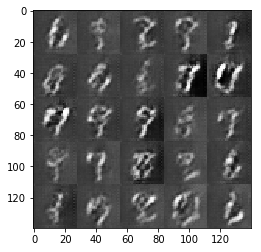

Epoch 1, step 450    Discriminator Loss: 1.3347    Generator Loss:  0.4389   
Epoch 1, step 500    Discriminator Loss: 1.1191    Generator Loss:  0.8886   


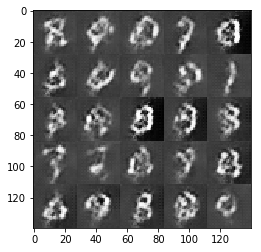

Epoch 1, step 550    Discriminator Loss: 1.2606    Generator Loss:  0.6802   
Epoch 1, step 600    Discriminator Loss: 1.1360    Generator Loss:  1.0391   


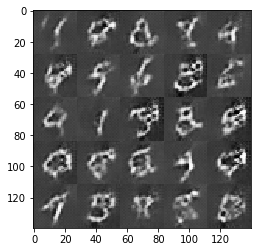

Epoch 1, step 650    Discriminator Loss: 1.2724    Generator Loss:  0.7600   
Epoch 1, step 700    Discriminator Loss: 1.2300    Generator Loss:  0.6590   


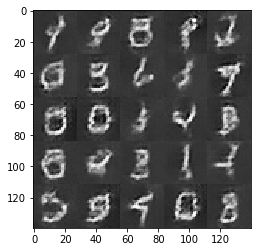

Epoch 1, step 750    Discriminator Loss: 1.2702    Generator Loss:  0.7280   
Epoch 1, step 800    Discriminator Loss: 1.1975    Generator Loss:  0.6469   


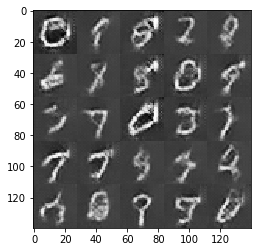

Epoch 1, step 850    Discriminator Loss: 1.1679    Generator Loss:  1.4787   
Epoch 1, step 900    Discriminator Loss: 1.5353    Generator Loss:  0.3766   


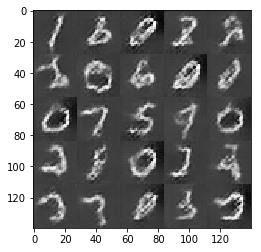

epoch 1 finished
Epoch 2, step 950    Discriminator Loss: 1.2657    Generator Loss:  0.6740   
Epoch 2, step 1000    Discriminator Loss: 1.2738    Generator Loss:  0.8055   


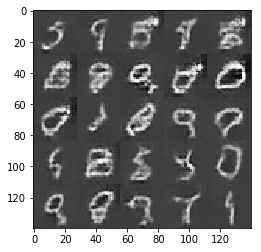

Epoch 2, step 1050    Discriminator Loss: 1.2398    Generator Loss:  0.7804   
Epoch 2, step 1100    Discriminator Loss: 1.3472    Generator Loss:  0.8390   


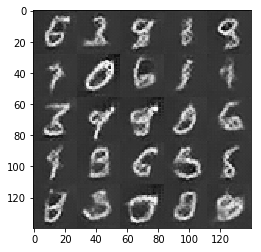

Epoch 2, step 1150    Discriminator Loss: 1.4654    Generator Loss:  0.4817   
Epoch 2, step 1200    Discriminator Loss: 1.3078    Generator Loss:  0.6704   


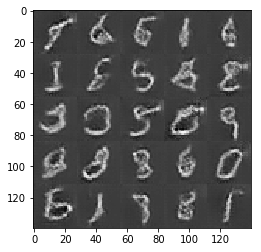

Epoch 2, step 1250    Discriminator Loss: 1.3258    Generator Loss:  0.7759   
Epoch 2, step 1300    Discriminator Loss: 1.4026    Generator Loss:  0.7079   


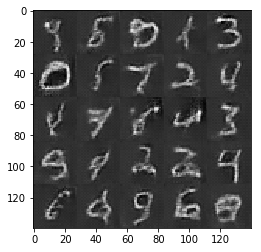

Epoch 2, step 1350    Discriminator Loss: 1.2451    Generator Loss:  0.7428   
Epoch 2, step 1400    Discriminator Loss: 1.2633    Generator Loss:  0.6859   


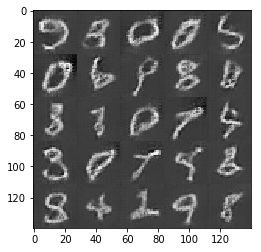

Epoch 2, step 1450    Discriminator Loss: 1.1923    Generator Loss:  1.4714   
Epoch 2, step 1500    Discriminator Loss: 1.2960    Generator Loss:  0.6404   


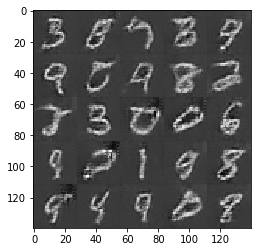

Epoch 2, step 1550    Discriminator Loss: 1.2584    Generator Loss:  0.7012   
Epoch 2, step 1600    Discriminator Loss: 1.3046    Generator Loss:  1.8882   


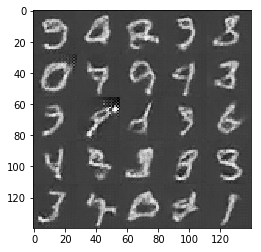

Epoch 2, step 1650    Discriminator Loss: 1.3150    Generator Loss:  0.8065   
Epoch 2, step 1700    Discriminator Loss: 1.2223    Generator Loss:  0.8536   


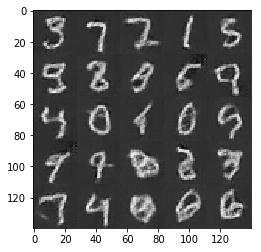

Epoch 2, step 1750    Discriminator Loss: 1.0847    Generator Loss:  1.3111   
Epoch 2, step 1800    Discriminator Loss: 1.4030    Generator Loss:  0.6034   


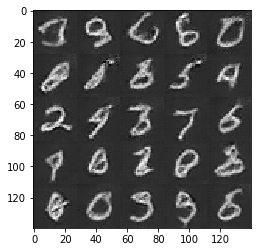

Epoch 2, step 1850    Discriminator Loss: 1.2792    Generator Loss:  0.7050   
epoch 2 finished


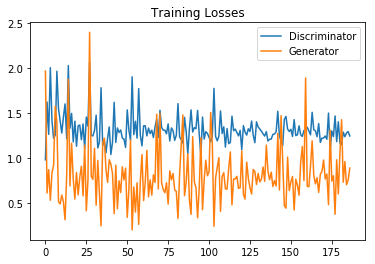

In [552]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1, step 50    Discriminator Loss: 1.0663    Generator Loss:  1.0878   
Epoch 1, step 100    Discriminator Loss: 1.2530    Generator Loss:  0.6980   


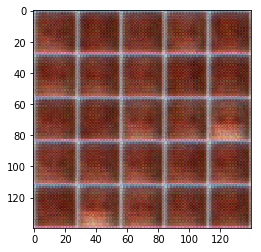

Epoch 1, step 150    Discriminator Loss: 1.3275    Generator Loss:  0.6025   
Epoch 1, step 200    Discriminator Loss: 1.2958    Generator Loss:  0.7754   


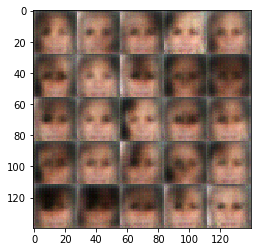

Epoch 1, step 250    Discriminator Loss: 1.2797    Generator Loss:  0.7661   
Epoch 1, step 300    Discriminator Loss: 1.2604    Generator Loss:  0.9838   


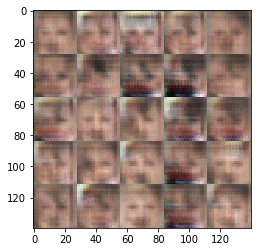

Epoch 1, step 350    Discriminator Loss: 1.3728    Generator Loss:  0.8589   
Epoch 1, step 400    Discriminator Loss: 1.1857    Generator Loss:  1.5523   


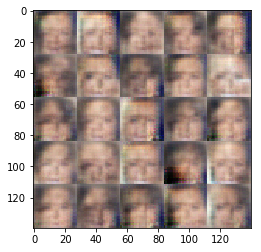

Epoch 1, step 450    Discriminator Loss: 1.2605    Generator Loss:  0.6676   
Epoch 1, step 500    Discriminator Loss: 0.9190    Generator Loss:  1.8330   


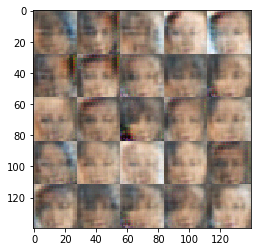

Epoch 1, step 550    Discriminator Loss: 0.9897    Generator Loss:  2.0149   
Epoch 1, step 600    Discriminator Loss: 1.2582    Generator Loss:  0.9265   


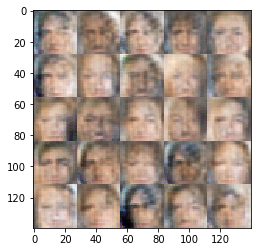

Epoch 1, step 650    Discriminator Loss: 1.1133    Generator Loss:  1.6836   
Epoch 1, step 700    Discriminator Loss: 1.3785    Generator Loss:  1.3137   


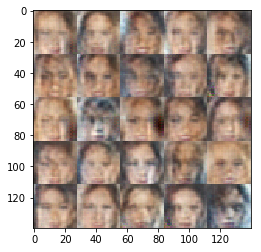

Epoch 1, step 750    Discriminator Loss: 1.3025    Generator Loss:  0.8970   
Epoch 1, step 800    Discriminator Loss: 1.3708    Generator Loss:  0.9461   


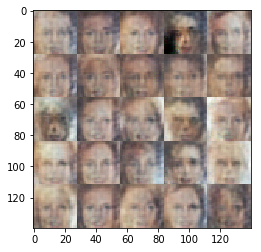

Epoch 1, step 850    Discriminator Loss: 1.3613    Generator Loss:  0.5711   
Epoch 1, step 900    Discriminator Loss: 1.3675    Generator Loss:  0.7878   


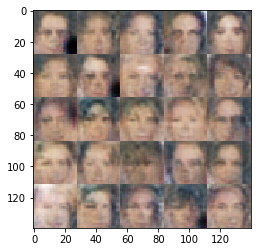

Epoch 1, step 950    Discriminator Loss: 1.2337    Generator Loss:  1.0796   
Epoch 1, step 1000    Discriminator Loss: 1.2512    Generator Loss:  1.0209   


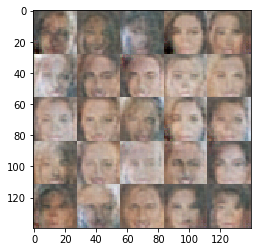

Epoch 1, step 1050    Discriminator Loss: 1.2939    Generator Loss:  0.8503   
Epoch 1, step 1100    Discriminator Loss: 1.2508    Generator Loss:  1.5501   


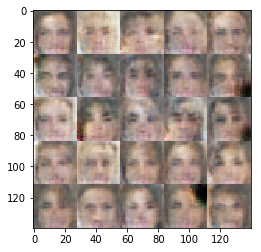

Epoch 1, step 1150    Discriminator Loss: 1.2274    Generator Loss:  1.2281   
Epoch 1, step 1200    Discriminator Loss: 1.1445    Generator Loss:  0.9671   


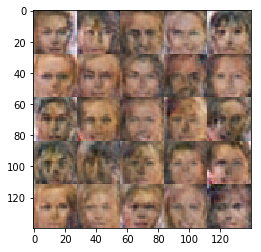

Epoch 1, step 1250    Discriminator Loss: 1.3504    Generator Loss:  0.7445   
Epoch 1, step 1300    Discriminator Loss: 1.2905    Generator Loss:  1.6015   


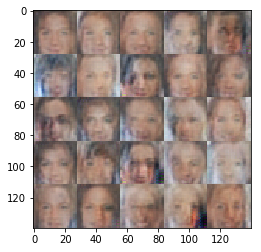

Epoch 1, step 1350    Discriminator Loss: 1.1277    Generator Loss:  1.2102   
Epoch 1, step 1400    Discriminator Loss: 1.1737    Generator Loss:  1.5443   


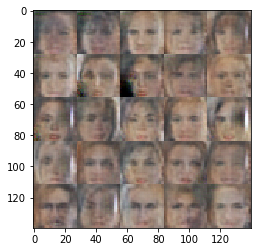

Epoch 1, step 1450    Discriminator Loss: 1.3195    Generator Loss:  0.8617   
Epoch 1, step 1500    Discriminator Loss: 1.1902    Generator Loss:  1.4309   


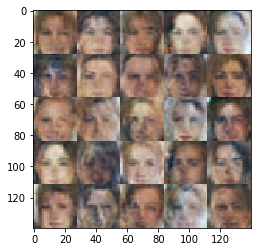

Epoch 1, step 1550    Discriminator Loss: 1.3417    Generator Loss:  0.9210   
Epoch 1, step 1600    Discriminator Loss: 1.2638    Generator Loss:  1.0800   


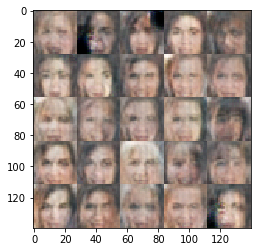

Epoch 1, step 1650    Discriminator Loss: 1.2939    Generator Loss:  1.1631   
Epoch 1, step 1700    Discriminator Loss: 1.2613    Generator Loss:  0.9485   


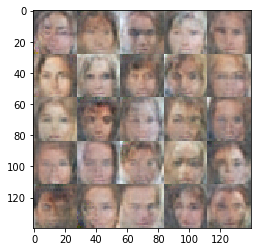

Epoch 1, step 1750    Discriminator Loss: 1.2920    Generator Loss:  0.9316   
Epoch 1, step 1800    Discriminator Loss: 1.3281    Generator Loss:  0.8021   


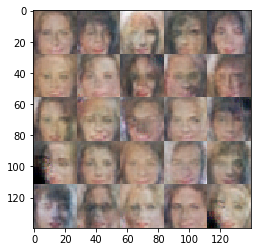

Epoch 1, step 1850    Discriminator Loss: 1.3427    Generator Loss:  0.7516   
Epoch 1, step 1900    Discriminator Loss: 1.2418    Generator Loss:  1.0868   


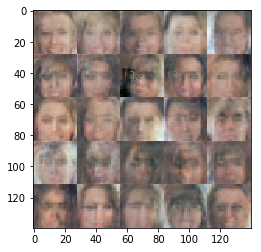

Epoch 1, step 1950    Discriminator Loss: 1.2277    Generator Loss:  0.7880   
Epoch 1, step 2000    Discriminator Loss: 1.3466    Generator Loss:  0.8650   


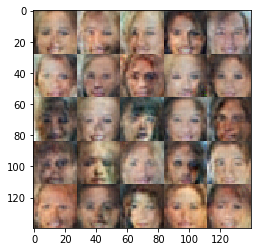

Epoch 1, step 2050    Discriminator Loss: 1.1236    Generator Loss:  0.8453   
Epoch 1, step 2100    Discriminator Loss: 1.1268    Generator Loss:  0.9973   


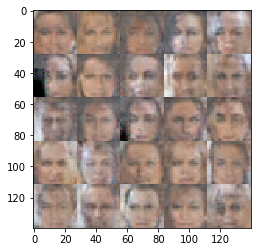

Epoch 1, step 2150    Discriminator Loss: 1.3011    Generator Loss:  1.1535   
Epoch 1, step 2200    Discriminator Loss: 1.0861    Generator Loss:  1.1588   


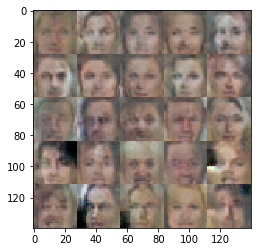

Epoch 1, step 2250    Discriminator Loss: 1.2779    Generator Loss:  0.9042   
Epoch 1, step 2300    Discriminator Loss: 1.3348    Generator Loss:  0.7283   


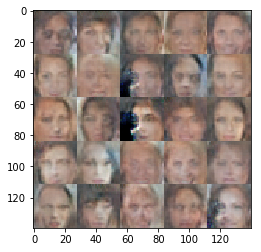

Epoch 1, step 2350    Discriminator Loss: 1.2992    Generator Loss:  0.9457   
Epoch 1, step 2400    Discriminator Loss: 1.2716    Generator Loss:  1.0527   


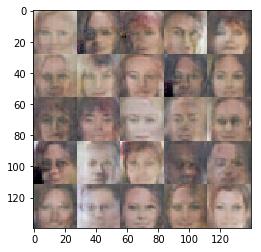

Epoch 1, step 2450    Discriminator Loss: 1.2874    Generator Loss:  0.8979   
Epoch 1, step 2500    Discriminator Loss: 0.7024    Generator Loss:  2.2173   


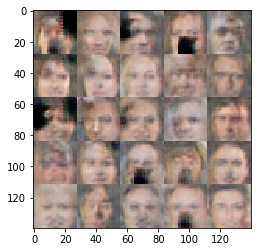

Epoch 1, step 2550    Discriminator Loss: 1.2005    Generator Loss:  0.9764   
Epoch 1, step 2600    Discriminator Loss: 1.3443    Generator Loss:  0.6132   


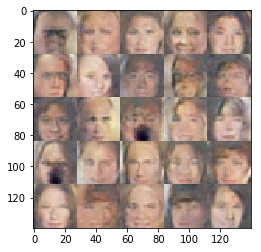

Epoch 1, step 2650    Discriminator Loss: 1.2351    Generator Loss:  1.0956   
Epoch 1, step 2700    Discriminator Loss: 1.2704    Generator Loss:  0.7577   


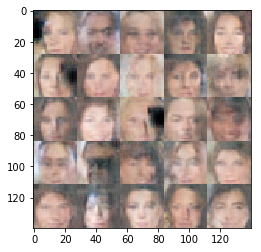

Epoch 1, step 2750    Discriminator Loss: 1.0974    Generator Loss:  1.8299   
Epoch 1, step 2800    Discriminator Loss: 1.3499    Generator Loss:  0.6766   


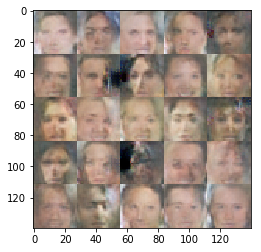

Epoch 1, step 2850    Discriminator Loss: 1.3831    Generator Loss:  1.2644   
Epoch 1, step 2900    Discriminator Loss: 1.2432    Generator Loss:  1.1596   


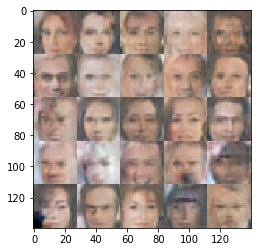

Epoch 1, step 2950    Discriminator Loss: 1.3382    Generator Loss:  0.9758   
Epoch 1, step 3000    Discriminator Loss: 1.2557    Generator Loss:  1.0325   


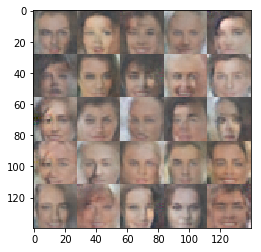

Epoch 1, step 3050    Discriminator Loss: 1.3399    Generator Loss:  0.8451   
Epoch 1, step 3100    Discriminator Loss: 1.2844    Generator Loss:  1.7722   


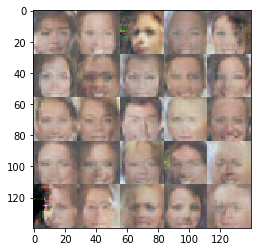

Epoch 1, step 3150    Discriminator Loss: 1.3331    Generator Loss:  0.8778   
epoch 1 finished
Epoch 2, step 3200    Discriminator Loss: 1.2838    Generator Loss:  0.8386   


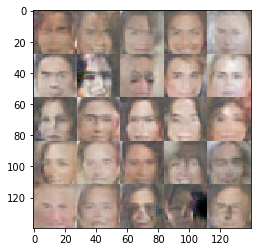

Epoch 2, step 3250    Discriminator Loss: 1.3110    Generator Loss:  1.1097   
Epoch 2, step 3300    Discriminator Loss: 1.3232    Generator Loss:  0.8653   


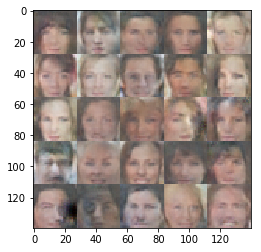

Epoch 2, step 3350    Discriminator Loss: 1.3561    Generator Loss:  1.2605   
Epoch 2, step 3400    Discriminator Loss: 1.3417    Generator Loss:  0.9666   


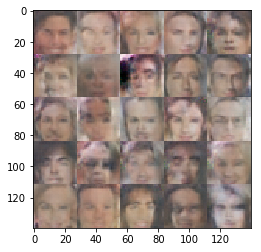

Epoch 2, step 3450    Discriminator Loss: 1.3107    Generator Loss:  1.0503   
Epoch 2, step 3500    Discriminator Loss: 1.2424    Generator Loss:  0.8072   


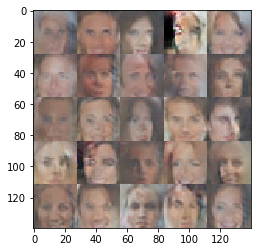

Epoch 2, step 3550    Discriminator Loss: 1.2538    Generator Loss:  1.1632   
Epoch 2, step 3600    Discriminator Loss: 1.2648    Generator Loss:  1.3885   


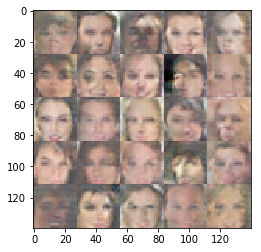

Epoch 2, step 3650    Discriminator Loss: 1.1996    Generator Loss:  1.2984   
Epoch 2, step 3700    Discriminator Loss: 1.2699    Generator Loss:  0.9269   


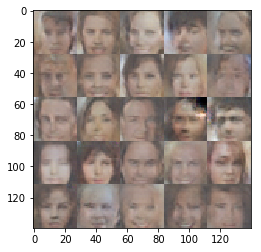

Epoch 2, step 3750    Discriminator Loss: 1.3113    Generator Loss:  0.8881   
Epoch 2, step 3800    Discriminator Loss: 1.2258    Generator Loss:  1.1383   


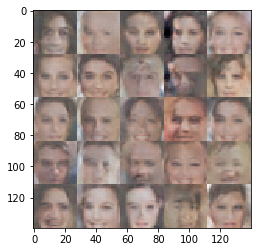

Epoch 2, step 3850    Discriminator Loss: 1.3930    Generator Loss:  1.2385   
Epoch 2, step 3900    Discriminator Loss: 1.2694    Generator Loss:  0.8577   


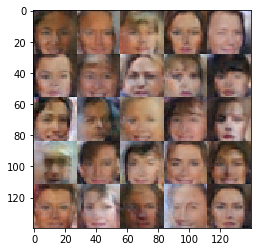

Epoch 2, step 3950    Discriminator Loss: 1.3273    Generator Loss:  0.8932   
Epoch 2, step 4000    Discriminator Loss: 1.2894    Generator Loss:  1.0649   


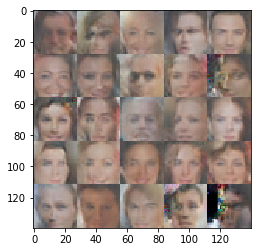

Epoch 2, step 4050    Discriminator Loss: 1.2483    Generator Loss:  0.8351   
Epoch 2, step 4100    Discriminator Loss: 1.3155    Generator Loss:  1.0884   


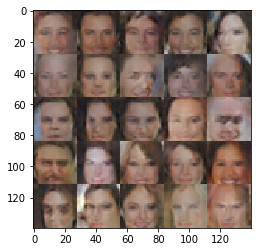

Epoch 2, step 4150    Discriminator Loss: 1.2564    Generator Loss:  1.1519   
Epoch 2, step 4200    Discriminator Loss: 1.3308    Generator Loss:  0.8001   


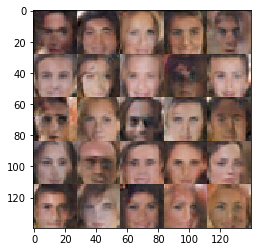

Epoch 2, step 4250    Discriminator Loss: 1.2858    Generator Loss:  1.1984   
Epoch 2, step 4300    Discriminator Loss: 1.1451    Generator Loss:  0.9978   


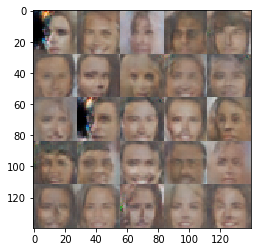

Epoch 2, step 4350    Discriminator Loss: 1.2380    Generator Loss:  0.8364   
Epoch 2, step 4400    Discriminator Loss: 1.2851    Generator Loss:  0.9564   


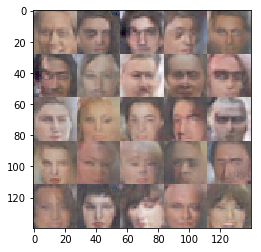

Epoch 2, step 4450    Discriminator Loss: 1.2697    Generator Loss:  1.0517   
Epoch 2, step 4500    Discriminator Loss: 1.3275    Generator Loss:  1.0425   


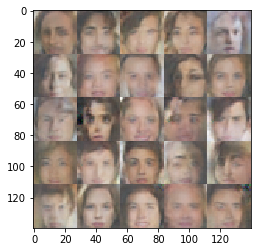

Epoch 2, step 4550    Discriminator Loss: 1.2860    Generator Loss:  0.7498   
Epoch 2, step 4600    Discriminator Loss: 1.1482    Generator Loss:  1.1483   


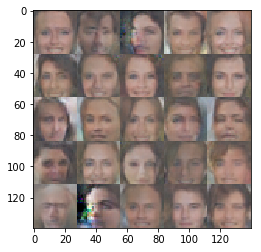

Epoch 2, step 4650    Discriminator Loss: 1.2418    Generator Loss:  1.0752   
Epoch 2, step 4700    Discriminator Loss: 1.3127    Generator Loss:  0.7794   


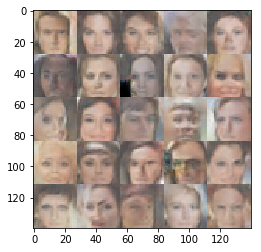

Epoch 2, step 4750    Discriminator Loss: 1.3088    Generator Loss:  0.7184   
Epoch 2, step 4800    Discriminator Loss: 1.4394    Generator Loss:  0.8319   


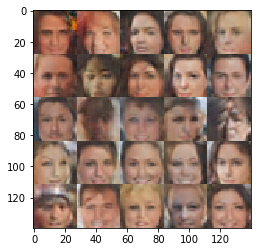

Epoch 2, step 4850    Discriminator Loss: 1.2829    Generator Loss:  0.9720   
Epoch 2, step 4900    Discriminator Loss: 1.3300    Generator Loss:  0.7896   


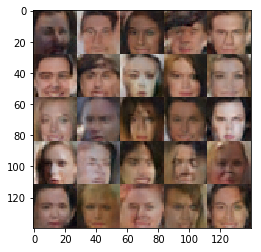

Epoch 2, step 4950    Discriminator Loss: 1.4080    Generator Loss:  0.6746   
Epoch 2, step 5000    Discriminator Loss: 1.2661    Generator Loss:  0.9759   


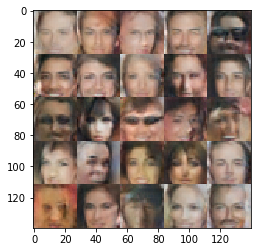

Epoch 2, step 5050    Discriminator Loss: 1.3570    Generator Loss:  0.8014   
Epoch 2, step 5100    Discriminator Loss: 1.1368    Generator Loss:  0.8973   


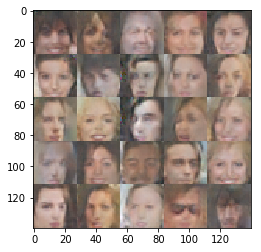

Epoch 2, step 5150    Discriminator Loss: 1.2763    Generator Loss:  0.7820   
Epoch 2, step 5200    Discriminator Loss: 1.3969    Generator Loss:  0.7986   


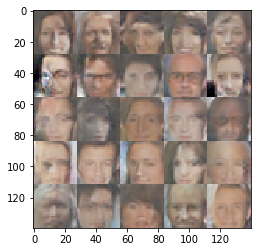

Epoch 2, step 5250    Discriminator Loss: 1.2360    Generator Loss:  0.8073   
Epoch 2, step 5300    Discriminator Loss: 1.4246    Generator Loss:  0.6669   


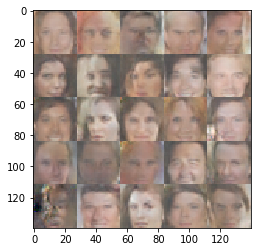

Epoch 2, step 5350    Discriminator Loss: 1.3370    Generator Loss:  1.2159   
Epoch 2, step 5400    Discriminator Loss: 1.2394    Generator Loss:  0.8478   


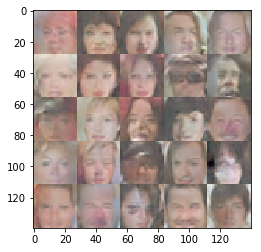

Epoch 2, step 5450    Discriminator Loss: 1.2032    Generator Loss:  0.8685   
Epoch 2, step 5500    Discriminator Loss: 1.3427    Generator Loss:  0.7522   


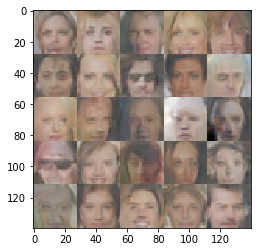

Epoch 2, step 5550    Discriminator Loss: 1.3433    Generator Loss:  0.8488   
Epoch 2, step 5600    Discriminator Loss: 1.4012    Generator Loss:  0.7756   


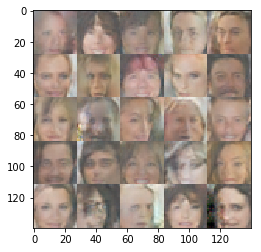

Epoch 2, step 5650    Discriminator Loss: 1.3959    Generator Loss:  0.5624   
Epoch 2, step 5700    Discriminator Loss: 1.3194    Generator Loss:  0.8526   


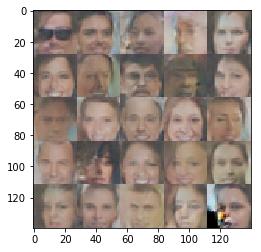

Epoch 2, step 5750    Discriminator Loss: 1.2725    Generator Loss:  0.9761   
Epoch 2, step 5800    Discriminator Loss: 1.1803    Generator Loss:  0.9019   


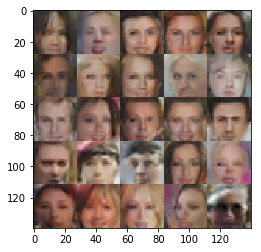

Epoch 2, step 5850    Discriminator Loss: 1.2878    Generator Loss:  0.8522   
Epoch 2, step 5900    Discriminator Loss: 1.2721    Generator Loss:  0.9511   


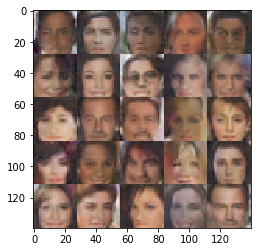

Epoch 2, step 5950    Discriminator Loss: 1.2907    Generator Loss:  0.6052   
Epoch 2, step 6000    Discriminator Loss: 1.3756    Generator Loss:  1.0941   


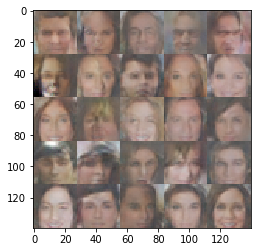

Epoch 2, step 6050    Discriminator Loss: 1.3594    Generator Loss:  1.2840   
Epoch 2, step 6100    Discriminator Loss: 1.2536    Generator Loss:  1.0135   


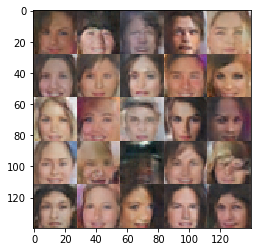

Epoch 2, step 6150    Discriminator Loss: 1.3151    Generator Loss:  0.7698   
Epoch 2, step 6200    Discriminator Loss: 1.1931    Generator Loss:  0.9577   


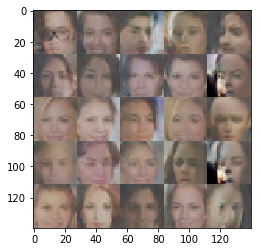

Epoch 2, step 6250    Discriminator Loss: 1.2130    Generator Loss:  1.0104   
Epoch 2, step 6300    Discriminator Loss: 1.1134    Generator Loss:  0.9369   


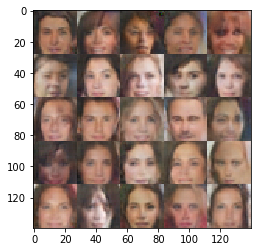

epoch 2 finished


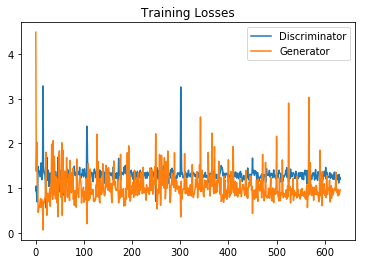

In [548]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


#NOTE:  I ended up running it for two epochs.  
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.